# Microservices Workload Prediction Experiment

This notebook demonstrates workload prediction using the Alibaba Microservices Trace v2022 dataset.

## Contents
1. Data Loading and Exploration
2. Data Analysis and Visualization
3. Data Preprocessing
4. Model Training and Evaluation
5. Results Comparison


# Environment

nvidia rtx 5090
cuda 13.0

## 1. Setup and Imports


In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Add project path
project_path = '/root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

# Import project modules
from config import DATA_CONFIG, MODEL_CONFIG, EXPERIMENT_CONFIG, create_output_dirs
from data_loader import DataModule, MSMetricsLoader, MSRTMCRLoader
from data_analysis import WorkloadAnalyzer, WorkloadVisualizer, analyze_dataset
from models import (
    create_model, get_available_models, get_model_info,
    LSTMPredictor, GRUPredictor, TransformerPredictor,
    AttentionLSTM, TCNPredictor, NLinear, DLinear,
    PatchTST, Informer, TimesNet, Autoformer
)
from trainer import (
    WorkloadTrainer, 
    run_deep_learning_experiment,
    run_baseline_experiment,
    compare_all_models,
    compute_metrics,
    print_metrics,
    plot_training_history,
    plot_predictions,
    plot_model_comparison,
    plot_comprehensive_comparison,
    generate_latex_table
)
from baseline_models import get_all_baseline_models, compare_baselines

# Create output directories
create_output_dirs()

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('Setup complete!')
print(f'Data root: {DATA_CONFIG.data_root}')
print(f'\nAvailable deep learning models: {get_available_models()}')

Setup complete!
Data root: /root/autodl-tmp/clusterdata/data

Available deep learning models: ['lstm', 'gru', 'attention_lstm', 'transformer', 'patchtst', 'informer', 'autoformer', 'tcn', 'timesnet', 'nlinear', 'dlinear']


## 2. Data Loading


In [2]:
# Initialize data module
dm = DataModule()

# Load MSMetrics data (adjust num_files based on your data)
# Each file covers 30 minutes, so:
#   4 files = 2 hours, 24 files = 12 hours (full dataset)
NUM_MSMETRICS_FILES = 24  # Use all available data for better results
LOAD_MSRTMCR = False      # Set True to load call rate/response time features

print('Loading data...')
dm.load_data(
    num_msmetrics_files=NUM_MSMETRICS_FILES,
    load_msrtmcr=LOAD_MSRTMCR,
    verbose=True
)

Loading data...
Loading MSMetrics data...
Loaded MSMetrics file 5/24
Loaded MSMetrics file 10/24
Loaded MSMetrics file 15/24
Loaded MSMetrics file 20/24
Total MSMetrics records: 336,805,458

MSMetrics Data Shape: (336805458, 6)
Unique microservices: 28,213
Timestamp range: 0 - 43140000


In [3]:
# Examine the loaded data
print('\nData shape:', dm.msmetrics_data.shape)
print('\nColumn names:', dm.msmetrics_data.columns.tolist())
print('\nData types:')
print(dm.msmetrics_data.dtypes)
print('\nFirst few rows:')
dm.msmetrics_data.head(10)


Data shape: (336805458, 6)

Column names: ['timestamp', 'msname', 'msinstanceid', 'nodeid', 'cpu_utilization', 'memory_utilization']

Data types:
timestamp               int64
msname                 object
msinstanceid           object
nodeid                 object
cpu_utilization       float64
memory_utilization    float64
dtype: object

First few rows:


,timestamp,msname,msinstanceid,nodeid,cpu_utilization,memory_utilization
0,3720000,MS_61151,MS_61151_POD_42,NODE_9945,0.051887,0.698518
1,3780000,MS_5436,MS_5436_POD_2,NODE_421,0.076700,0.684867
2,4140000,MS_304,MS_304_POD_170,NODE_16704,0.093711,0.479342
3,4140000,MS_48931,MS_48931_POD_510,NODE_25130,0.110925,0.587354
4,4320000,MS_53714,MS_53714_POD_747,NODE_39212,0.048708,0.683524
5,4440000,MS_67168,MS_67168_POD_20,NODE_36821,0.159120,0.662062
6,4440000,MS_52217,MS_52217_POD_1,NODE_31186,0.077220,0.738218
7,4500000,MS_69077,MS_69077_POD_2,NODE_21815,0.038056,0.680977
8,4500000,MS_31422,MS_31422_POD_14,NODE_19434,0.184500,0.788476
9,4680000,MS_47454,MS_47454_POD_37,NODE_43855,0.027354,0.272962


In [4]:
# Basic statistics
print('Basic statistics:')
dm.msmetrics_data.describe()

Basic statistics:


,timestamp,cpu_utilization,memory_utilization
count,3.368055e+08,3.368055e+08,3.368055e+08
mean,2.161069e+07,1.545188e-01,6.020451e-01
std,1.247322e+07,1.374364e-01,1.793739e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.080000e+07,6.384000e-02,5.074000e-01
50%,2.166000e+07,1.108217e-01,6.403999e-01
75%,3.240000e+07,1.980900e-01,7.187867e-01
max,4.314000e+07,1.000000e+00,9.997531e-01


## 3. Data Analysis and Visualization


In [5]:
# Initialize analyzer and visualizer with optimized settings
analyzer = WorkloadAnalyzer(sample_size=1_000_000)  # Limit sample size for speed
visualizer = WorkloadVisualizer()

# Run comprehensive analysis with FAST MODE (uses sampling for large datasets)
stats, service_stats, temporal = analyze_dataset(
    dm.msmetrics_data, 
    fast_mode=True,      # Use optimized analysis with sampling
    sample_size=1_000_000  # Sample size for visualization
)

WORKLOAD DATA ANALYSIS [OPTIMIZED]
Dataset size: 336,805,458 records

0. Quick Overview
----------------------------------------
  Total records: 336,805,458
  Unique services: 28,213
  Time duration: 12.0 hours
  CPU utilization: mean=0.1545, std=0.1374

1. Basic Statistics
----------------------------------------
  [Sampling] Original size: 336,805,458, sampling to ~1,000,000
                cpu_utilization  memory_utilization
count            1000000.000000      1000000.000000
mean                   0.154460            0.601979
std                    0.137305            0.179478
min                    0.000000            0.000000
25%                    0.063851            0.506951
50%                    0.110880            0.640436
75%                    0.197938            0.718820
max                    0.999875            0.998176
skewness               2.136096           -1.072948
kurtosis               5.886972            1.194533
non_zero_ratio         0.999966            0.99

In [6]:
# Get top microservices by data volume
top_services = dm.get_top_services(20)
print('Top 20 microservices by data points:')
for i, (svc, count) in enumerate(top_services, 1):
    print(f'  {i}. {svc}: {count:,} records')

Top 20 microservices by data points:
  1. MS_6945: 5,543,522 records
  2. MS_43157: 1,432,289 records
  3. MS_42222: 1,333,440 records
  4. MS_66711: 1,223,594 records
  5. MS_19988: 1,198,052 records
  6. MS_29860: 1,151,248 records
  7. MS_48534: 1,139,741 records
  8. MS_10489: 1,115,712 records
  9. MS_491: 1,076,364 records
  10. MS_73317: 1,066,389 records
  11. MS_27721: 1,037,256 records
  12. MS_38464: 1,023,831 records
  13. MS_70053: 1,021,653 records
  14. MS_63360: 999,937 records
  15. MS_68948: 935,985 records
  16. MS_72474: 935,794 records
  17. MS_57387: 903,818 records
  18. MS_21035: 887,684 records
  19. MS_27381: 863,272 records
  20. MS_53782: 862,908 records


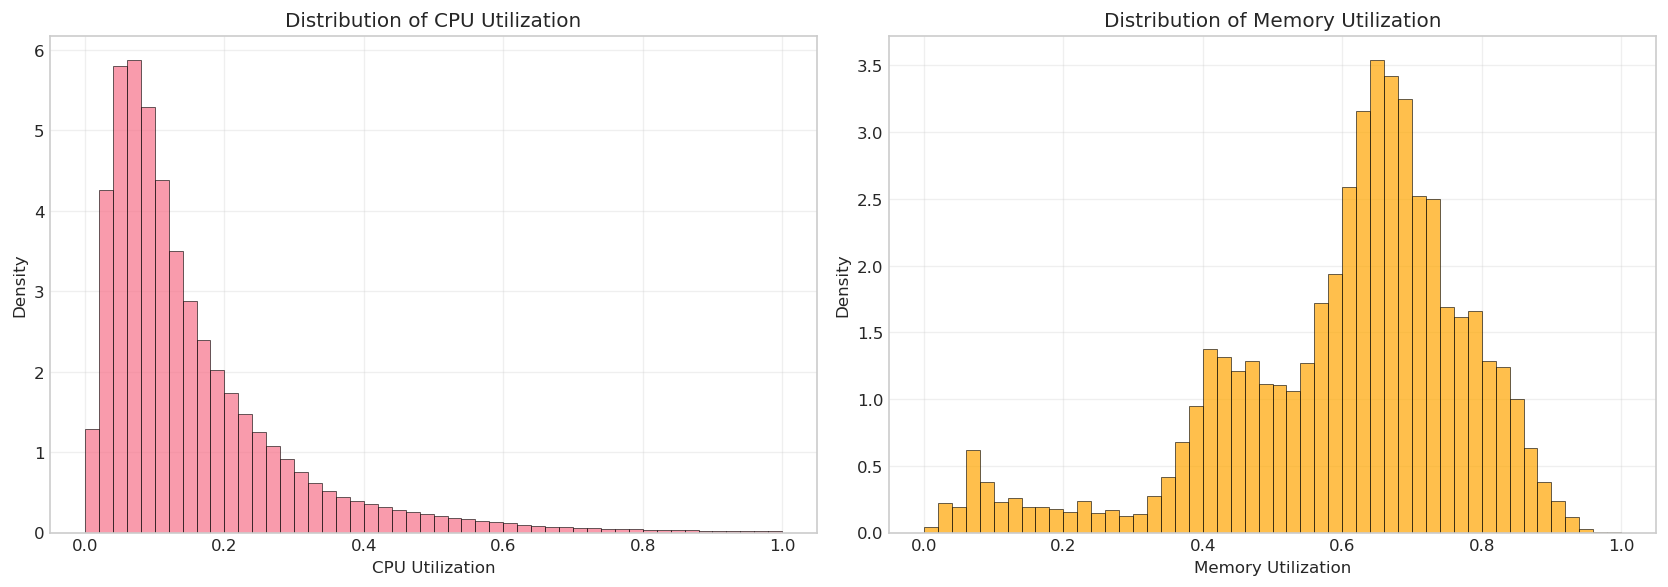

In [7]:
# Visualize distribution of CPU and memory utilization
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# CPU utilization distribution
axes[0].hist(dm.msmetrics_data['cpu_utilization'].dropna(), bins=50, 
             density=True, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('CPU Utilization')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of CPU Utilization')
axes[0].grid(True, alpha=0.3)

# Memory utilization distribution
axes[1].hist(dm.msmetrics_data['memory_utilization'].dropna(), bins=50,
             density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color='orange')
axes[1].set_xlabel('Memory Utilization')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Memory Utilization')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_CONFIG.figures_path, 'utilization_distribution.png'), dpi=150)
plt.show()

## 4. Prepare Data for Prediction


In [8]:
# Select a microservice for prediction
# Choose one with sufficient data points
MIN_DATA_POINTS = 200

# Find services with enough data
service_candidates = []
for svc, count in top_services:
    if count >= MIN_DATA_POINTS:
        service_candidates.append((svc, count))

print(f'Found {len(service_candidates)} services with >= {MIN_DATA_POINTS} data points')

if service_candidates:
    # Select the service with most data
    selected_service = service_candidates[0][0]
    print(f'\nSelected service for prediction: {selected_service}')
    print(f'Data points: {service_candidates[0][1]:,}')
else:
    print('No suitable service found. Please load more data.')

Found 20 services with >= 200 data points

Selected service for prediction: MS_6945
Data points: 5,543,522


In [9]:
# Prepare time series data for the selected service
if 'selected_service' in dir():
    ts_data = dm.prepare_service_data(
        selected_service,
        features=['cpu_utilization', 'memory_utilization'],
        normalize=True,
        add_features=False  # Set to True to add lag/rolling features
    )
    
    if ts_data is not None:
        print(f'Time series shape: {ts_data.shape}')
        print(f'Features: {ts_data.columns.tolist()}')
        print(f'\nTime series statistics:')
        print(ts_data.describe())
    else:
        print('Failed to prepare time series data')

Time series shape: (720, 2)
Features: ['cpu_utilization', 'memory_utilization']

Time series statistics:
       cpu_utilization  memory_utilization
count       720.000000          720.000000
mean          0.466272            0.434982
std           0.273783            0.260686
min           0.000000            0.000000
25%           0.233507            0.231655
50%           0.448085            0.364727
75%           0.725961            0.695041
max           1.000000            1.000000


In [10]:
# Create DataLoaders
if 'ts_data' in dir() and ts_data is not None:
    print('Creating DataLoaders...')
    print(f'Sequence length: {MODEL_CONFIG.seq_length}')
    print(f'Prediction horizon: {MODEL_CONFIG.pred_length}')
    print(f'Batch size: {MODEL_CONFIG.batch_size}')
    
    train_loader, val_loader, test_loader = dm.create_dataloaders(
        ts_data.values,
        target_idx=0  # Predict CPU utilization
    )
    
    # Verify data shapes
    for x, y in train_loader:
        print(f'\nBatch shapes:')
        print(f'  Input (X): {x.shape}')
        print(f'  Target (Y): {y.shape}')
        break

Creating DataLoaders...
Sequence length: 12
Prediction horizon: 1
Batch size: 32
Data split - Train: 503, Val: 109, Test: 108
Train samples: 491
Val samples: 97
Test samples: 96

Batch shapes:
  Input (X): torch.Size([32, 12, 2])
  Target (Y): torch.Size([32, 1])


## 5. Model Training


In [18]:
# Check for GPU availability and compatibility
import torch

def check_gpu_compatibility():
    """Check if GPU is available and compatible with PyTorch."""
    print("=" * 60)
    print("GPU COMPATIBILITY CHECK")
    print("=" * 60)
    
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        
        # Test if CUDA actually works
        try:
            test_tensor = torch.zeros(1).cuda()
            test_result = test_tensor + 1
            del test_tensor, test_result
            print("\n✓ CUDA test passed! GPU can be used.")
            return 'cuda'
        except RuntimeError as e:
            print(f"\n✗ CUDA test failed: {e}")
            print("\nNote: Your GPU (RTX 5090) uses Blackwell architecture which may")
            print("require PyTorch 2.5+ with CUDA 13 support. Using CPU instead.")
            return 'cpu'
    else:
        print("\nNo CUDA-capable GPU detected. Using CPU.")
        return 'cpu'

# Run compatibility check
recommended_device = check_gpu_compatibility()
print(f"\nRecommended device: {recommended_device}")

# Set device for this notebook
device = torch.device(recommended_device)
print(f"Using device: {device}")

GPU COMPATIBILITY CHECK
PyTorch version: 2.10.0.dev20251207+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 5090
GPU Memory: 33.67 GB

✓ CUDA test passed! GPU can be used.

Recommended device: cuda
Using device: cuda


In [19]:
# ============================================================
# TRAIN ALL DEEP LEARNING MODELS
# ============================================================
# This section trains all 11 available models for comprehensive comparison

if 'train_loader' in dir():
    input_size = ts_data.shape[1]  # Number of features
    output_size = MODEL_CONFIG.pred_length
    seq_length = MODEL_CONFIG.seq_length
    
    print(f'Input size: {input_size}')
    print(f'Output size: {output_size}')
    print(f'Sequence length: {seq_length}')
    
    # Training configuration
    NUM_EPOCHS = 100  # Adjust as needed
    
    # Get all available models
    all_model_types = get_available_models()
    print(f'\nModels to train: {all_model_types}')
    print(f'Total: {len(all_model_types)} models')
    
    # Store all results
    all_dl_results = {}
    all_dl_trainers = {}
    
    # Train each model
    for model_type in all_model_types:
        print(f'\n{"="*60}')
        print(f'Training {model_type.upper()}...')
        print(f'{"="*60}')
        
        try:
            results, trainer = run_deep_learning_experiment(
                model_type=model_type,
                train_loader=train_loader,
                val_loader=val_loader,
                test_loader=test_loader,
                input_size=input_size,
                output_size=output_size,
                seq_length=seq_length,
                num_epochs=NUM_EPOCHS
            )
            
            all_dl_results[model_type] = results
            all_dl_trainers[model_type] = trainer
            
            print(f'\n✓ {model_type.upper()} completed successfully')
            
        except Exception as e:
            print(f'\n✗ {model_type.upper()} failed: {e}')
            all_dl_results[model_type] = None
    
    print(f'\n{"="*60}')
    print(f'TRAINING COMPLETE')
    print(f'{"="*60}')
    print(f'Successfully trained: {sum(1 for v in all_dl_results.values() if v is not None)}/{len(all_model_types)} models')

Input size: 2
Output size: 1
Sequence length: 12

Models to train: ['lstm', 'gru', 'attention_lstm', 'transformer', 'patchtst', 'informer', 'autoformer', 'tcn', 'timesnet', 'nlinear', 'dlinear']
Total: 11 models

Training LSTM...

Running Experiment: LSTM
Model parameters: 54,913
Using device: cuda
Starting Training
  Epochs: 100
  Batch size: 32
  Learning rate: 0.0005
Epoch [1/100] Train Loss: 0.192943 Val Loss: 0.884230 Train MAE: 0.400299 Val MAE: 0.934989 Time: 0.14s
Epoch [10/100] Train Loss: 0.026727 Val Loss: 0.203271 Train MAE: 0.130174 Val MAE: 0.442882 Time: 0.13s
Epoch [20/100] Train Loss: 0.015370 Val Loss: 0.028575 Train MAE: 0.096967 Val MAE: 0.142120 Time: 0.12s
Epoch [30/100] Train Loss: 0.008045 Val Loss: 0.006674 Train MAE: 0.069335 Val MAE: 0.063752 Time: 0.11s
Epoch [40/100] Train Loss: 0.007919 Val Loss: 0.007532 Train MAE: 0.069673 Val MAE: 0.071709 Time: 0.11s
Epoch [50/100] Train Loss: 0.007337 Val Loss: 0.010736 Train MAE: 0.065137 Val MAE: 0.091656 Time: 0.08

In [20]:
# ============================================================
# TRAIN BASELINE MODELS
# ============================================================
# Compare with traditional ML baselines (Random Forest, XGBoost, etc.)

if 'train_loader' in dir():
    print('='*60)
    print('TRAINING BASELINE MODELS')
    print('='*60)
    
    # Extract numpy arrays from DataLoaders for baseline models
    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []
    
    for x, y in train_loader:
        X_train_list.append(x.numpy())
        y_train_list.append(y.numpy())
    
    if test_loader:
        for x, y in test_loader:
            X_test_list.append(x.numpy())
            y_test_list.append(y.numpy())
    
    X_train = np.concatenate(X_train_list)
    y_train = np.concatenate(y_train_list)
    X_test = np.concatenate(X_test_list)
    y_test = np.concatenate(y_test_list)
    
    print(f'Training data shape: X={X_train.shape}, y={y_train.shape}')
    print(f'Test data shape: X={X_test.shape}, y={y_test.shape}')
    
    # Run baseline experiments
    baseline_results_df = run_baseline_experiment(
        X_train, y_train, X_test, y_test,
        include_ml=True,  # Include ML models (XGBoost, LightGBM, Random Forest)
        verbose=True
    )
    
    print('\n' + '='*60)
    print('BASELINE RESULTS')
    print('='*60)
    print(baseline_results_df.to_string())

TRAINING BASELINE MODELS
Training data shape: X=(480, 12, 2), y=(480, 1)
Test data shape: X=(96, 12, 2), y=(96, 1)

BASELINE MODEL EXPERIMENTS

Evaluating Naive (Last Value)... RMSE: 0.0520, MAE: 0.0377

Evaluating Moving Average (window=3)... RMSE: 0.0571, MAE: 0.0438

Evaluating Moving Average (window=6)... RMSE: 0.0628, MAE: 0.0492

Evaluating Moving Average (window=12)... RMSE: 0.0654, MAE: 0.0499

Evaluating Exp Smoothing (alpha=0.2)... RMSE: 0.0592, MAE: 0.0453

Evaluating Exp Smoothing (alpha=0.5)... RMSE: 0.0528, MAE: 0.0402

Evaluating Seasonal Naive (period=12)... RMSE: 0.0953, MAE: 0.0714

Evaluating Linear Regression... RMSE: 0.0510, MAE: 0.0373

Evaluating Random Forest... RMSE: 0.2106, MAE: 0.1936

Evaluating XGBoost... Error: XGBoost not installed. Run: pip install xgboost

Evaluating LightGBM... Error: LightGBM not installed. Run: pip install lightgbm

BASELINE RESULTS
        mse      rmse       mae       mape      smape        r2                       model  training_

In [21]:
# ============================================================
# COMBINE ALL RESULTS FOR COMPARISON
# ============================================================

if 'all_dl_results' in dir() and 'baseline_results_df' in dir():
    # Combine deep learning results into a DataFrame
    dl_results_list = []
    
    for model_type, results in all_dl_results.items():
        if results is not None:
            dl_results_list.append({
                'model': model_type.upper(),
                'model_class': 'Deep Learning',
                'mse': results['eval_metrics'].get('mse', float('inf')),
                'rmse': results['eval_metrics'].get('rmse', float('inf')),
                'mae': results['eval_metrics'].get('mae', float('inf')),
                'mape': results['eval_metrics'].get('mape', float('inf')),
                'smape': results['eval_metrics'].get('smape', float('inf')),
                'r2': results['eval_metrics'].get('r2', float('-inf')),
                'training_time': results['training_time'],
                'num_params': results['num_params']
            })
    
    dl_results_df = pd.DataFrame(dl_results_list)
    
    # Add model_class to baseline results
    baseline_results_df['model_class'] = 'Baseline'
    baseline_results_df['num_params'] = 0
    baseline_results_df = baseline_results_df.rename(columns={'model': 'model'})
    
    # Combine all results
    all_results_df = pd.concat([
        dl_results_df,
        baseline_results_df[['model', 'model_class', 'mse', 'rmse', 'mae', 'mape', 'smape', 'r2', 'training_time', 'num_params']]
    ], ignore_index=True)
    
    # Sort by RMSE
    all_results_df = all_results_df.sort_values('rmse').reset_index(drop=True)
    
    print('='*80)
    print('COMPREHENSIVE MODEL COMPARISON (Sorted by RMSE)')
    print('='*80)
    print(all_results_df.to_string())
    
    # Save to CSV
    all_results_df.to_csv(
        os.path.join(EXPERIMENT_CONFIG.results_path, 'all_models_comparison.csv'),
        index=False
    )
    print(f'\nResults saved to: {EXPERIMENT_CONFIG.results_path}/all_models_comparison.csv')

COMPREHENSIVE MODEL COMPARISON (Sorted by RMSE)
                         model    model_class       mse      rmse       mae       mape      smape         r2  training_time  num_params
0                      NLINEAR  Deep Learning  0.002408  0.049069  0.036318   3.268722   3.284228   0.568837       1.231130          13
1            Linear Regression       Baseline  0.002596  0.050955  0.037274   3.319395   3.357729   0.535059       0.002508           0
2           Naive (Last Value)       Baseline  0.002705  0.052006  0.037728   3.390079   3.404924   0.515680       0.000007           0
3    Exp Smoothing (alpha=0.5)       Baseline  0.002791  0.052828  0.040228   3.597885   3.620100   0.500237       0.000310           0
4                          GRU  Deep Learning  0.003059  0.055309  0.043056   3.841149   3.881517   0.452196       9.814602       40129
5                      DLINEAR  Deep Learning  0.003249  0.056996  0.042502   3.797946   3.833261   0.418277       3.411367          26


## 6. Results Comparison


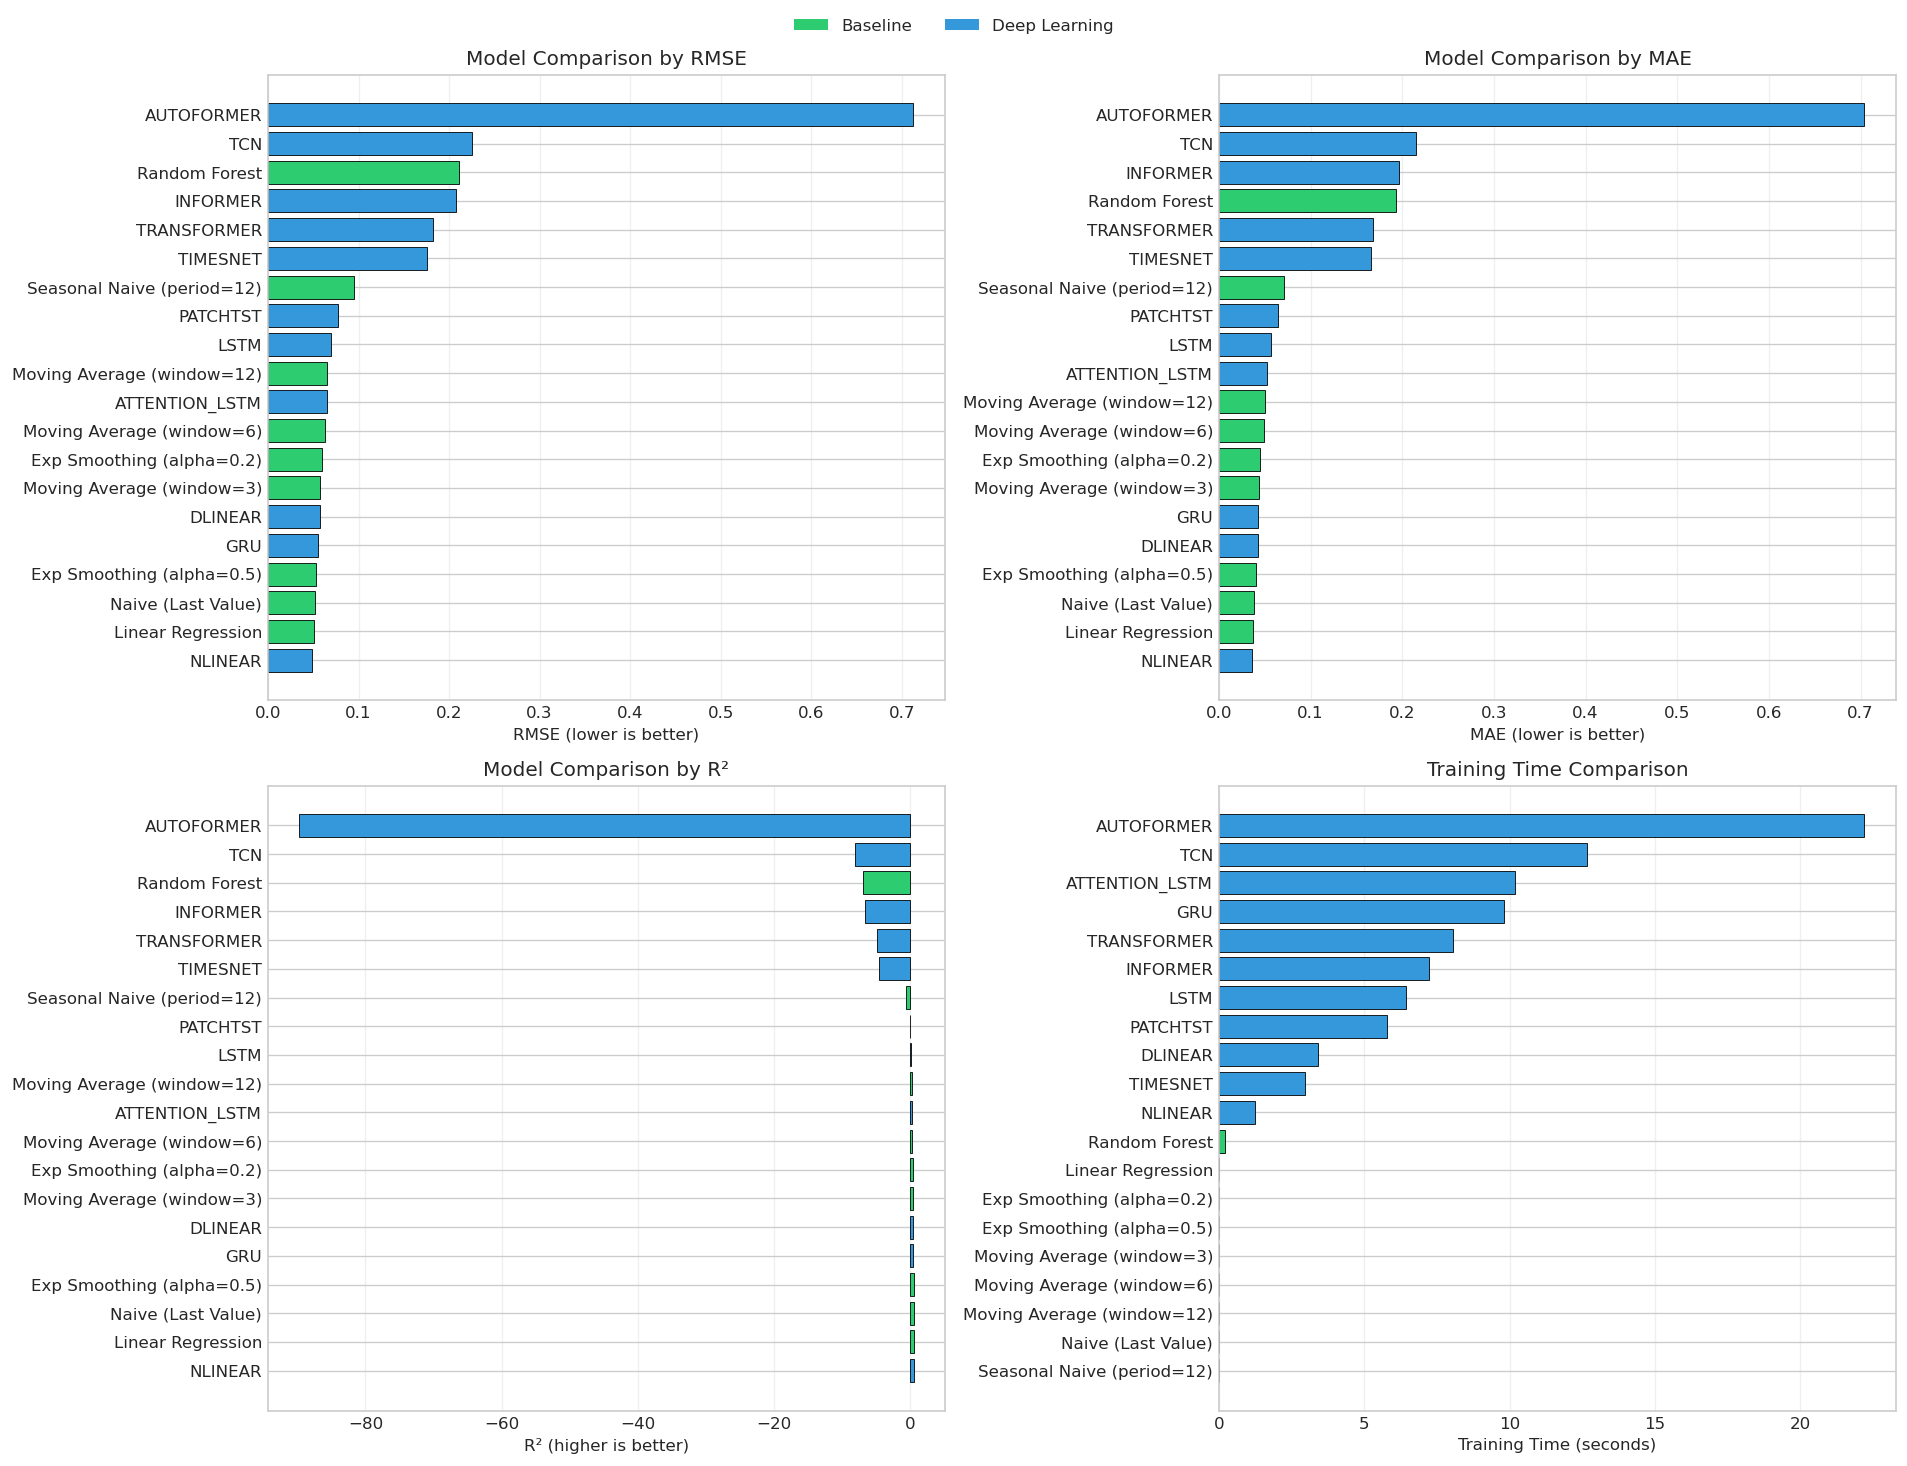


Generating comprehensive comparison plots...
Comprehensive comparison plots saved to: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/figures

All figures saved to: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/figures


In [22]:
# ============================================================
# VISUALIZE COMPARISON RESULTS
# ============================================================

if 'all_results_df' in dir() and len(all_results_df) > 0:
    # Rename columns for visualization
    viz_df = all_results_df.rename(columns={'model': 'model_type'})
    
    # 1. Bar chart comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=120)
    
    # RMSE comparison
    sorted_df = viz_df.sort_values('rmse')
    colors = ['#2ecc71' if c == 'Baseline' else '#3498db' for c in sorted_df['model_class']]
    axes[0, 0].barh(sorted_df['model_type'], sorted_df['rmse'], color=colors, edgecolor='black', linewidth=0.5)
    axes[0, 0].set_xlabel('RMSE (lower is better)')
    axes[0, 0].set_title('Model Comparison by RMSE')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # MAE comparison
    sorted_df = viz_df.sort_values('mae')
    colors = ['#2ecc71' if c == 'Baseline' else '#3498db' for c in sorted_df['model_class']]
    axes[0, 1].barh(sorted_df['model_type'], sorted_df['mae'], color=colors, edgecolor='black', linewidth=0.5)
    axes[0, 1].set_xlabel('MAE (lower is better)')
    axes[0, 1].set_title('Model Comparison by MAE')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # R² comparison
    sorted_df = viz_df.sort_values('r2', ascending=False)
    colors = ['#2ecc71' if c == 'Baseline' else '#3498db' for c in sorted_df['model_class']]
    axes[1, 0].barh(sorted_df['model_type'], sorted_df['r2'], color=colors, edgecolor='black', linewidth=0.5)
    axes[1, 0].set_xlabel('R² (higher is better)')
    axes[1, 0].set_title('Model Comparison by R²')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Training time comparison
    sorted_df = viz_df.sort_values('training_time')
    colors = ['#2ecc71' if c == 'Baseline' else '#3498db' for c in sorted_df['model_class']]
    axes[1, 1].barh(sorted_df['model_type'], sorted_df['training_time'], color=colors, edgecolor='black', linewidth=0.5)
    axes[1, 1].set_xlabel('Training Time (seconds)')
    axes[1, 1].set_title('Training Time Comparison')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2ecc71', label='Baseline'), Patch(facecolor='#3498db', label='Deep Learning')]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout()
    plt.savefig(os.path.join(EXPERIMENT_CONFIG.figures_path, 'model_comparison_comprehensive.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Generate comprehensive comparison plots
    print('\nGenerating comprehensive comparison plots...')
    plot_comprehensive_comparison(viz_df, save_dir=EXPERIMENT_CONFIG.figures_path)
    
    print(f'\nAll figures saved to: {EXPERIMENT_CONFIG.figures_path}')

In [23]:
# ============================================================
# EXPERIMENT SUMMARY
# ============================================================

print('='*80)
print('EXPERIMENT SUMMARY')
print('=' * 60)

print('='*80)

print(f'\nDataset: Alibaba Microservices Trace v2022')
print(f'   Target: {EXPERIMENT_CONFIG.target_variable}')
print(f'   Service: {selected_service}')
print(f'   Sequence length: {MODEL_CONFIG.seq_length} time steps')
print(f'   Prediction horizon: {MODEL_CONFIG.pred_length} time steps')

if 'all_results_df' in dir() and len(all_results_df) > 0:
    # Overall best model
    best_overall = all_results_df.loc[all_results_df['rmse'].idxmin()]
    
    print(f'\nBEST OVERALL MODEL: {best_overall["model"]}')
    print(f'   - RMSE:  {best_overall["rmse"]:.6f}')
    print(f'   - MAE:   {best_overall["mae"]:.6f}')
    print(f'   - R²:    {best_overall["r2"]:.6f}')
    print(f'   - MAPE:  {best_overall["mape"]:.2f}%')
    
    # Best deep learning model
    dl_results = all_results_df[all_results_df['model_class'] == 'Deep Learning']
    if len(dl_results) > 0:
        best_dl = dl_results.loc[dl_results['rmse'].idxmin()]
        print(f'\nBEST DEEP LEARNING MODEL: {best_dl["model"]}')
        print(f'   - RMSE:  {best_dl["rmse"]:.6f}')
        print(f'   - MAE:   {best_dl["mae"]:.6f}')
        print(f'   - R²:    {best_dl["r2"]:.6f}')
    
    # Best baseline model
    baseline_results = all_results_df[all_results_df['model_class'] == 'Baseline']
    if len(baseline_results) > 0:
        best_baseline = baseline_results.loc[baseline_results['rmse'].idxmin()]
        print(f'\nBEST BASELINE MODEL: {best_baseline["model"]}')
        print(f'   - RMSE:  {best_baseline["rmse"]:.6f}')
        print(f'   - MAE:   {best_baseline["mae"]:.6f}')
        print(f'   - R²:    {best_baseline["r2"]:.6f}')
    
    # Summary statistics
    print(f'\nSUMMARY STATISTICS:')
    print(f'   Total models evaluated: {len(all_results_df)}')
    print(f'   Deep learning models: {len(dl_results)}')
    print(f'   Baseline models: {len(baseline_results)}')
    
    # Top 5 models
    print(f'\nTOP 5 MODELS (by RMSE):')
    top5 = all_results_df.nsmallest(5, 'rmse')
    for i, (_, row) in enumerate(top5.iterrows(), 1):
        print(f'   {i}. {row["model"]}: RMSE={row["rmse"]:.6f}, R²={row["r2"]:.6f}')

print(f'\nOUTPUT FILES:')
print(f'   Results: {EXPERIMENT_CONFIG.results_path}/all_models_comparison.csv')
print(f'   Figures: {EXPERIMENT_CONFIG.figures_path}/')

# Generate LaTeX table for paper
if 'all_results_df' in dir():
    print(f'\nLaTeX Table for Paper:')
    print('-'*60)
    latex = generate_latex_table(all_results_df.rename(columns={'model': 'model_type'}))
    print(latex)
    
    # Save LaTeX to file
    with open(os.path.join(EXPERIMENT_CONFIG.results_path, 'results_table.tex'), 'w') as f:
        f.write(latex)
    print(f'\nLaTeX table saved to: {EXPERIMENT_CONFIG.results_path}/results_table.tex')

EXPERIMENT SUMMARY

Dataset: Alibaba Microservices Trace v2022
   Target: cpu_utilization
   Service: MS_6945
   Sequence length: 12 time steps
   Prediction horizon: 1 time steps

BEST OVERALL MODEL: NLINEAR
   - RMSE:  0.049069
   - MAE:   0.036318
   - R²:    0.568837
   - MAPE:  3.27%

BEST DEEP LEARNING MODEL: NLINEAR
   - RMSE:  0.049069
   - MAE:   0.036318
   - R²:    0.568837

BEST BASELINE MODEL: Linear Regression
   - RMSE:  0.050955
   - MAE:   0.037274
   - R²:    0.535059

SUMMARY STATISTICS:
   Total models evaluated: 20
   Deep learning models: 11
   Baseline models: 9

TOP 5 MODELS (by RMSE):
   1. NLINEAR: RMSE=0.049069, R²=0.568837
   2. Linear Regression: RMSE=0.050955, R²=0.535059
   3. Naive (Last Value): RMSE=0.052006, R²=0.515680
   4. Exp Smoothing (alpha=0.5): RMSE=0.052828, R²=0.500237
   5. GRU: RMSE=0.055309, R²=0.452196

OUTPUT FILES:
   Results: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/results/all_models_c

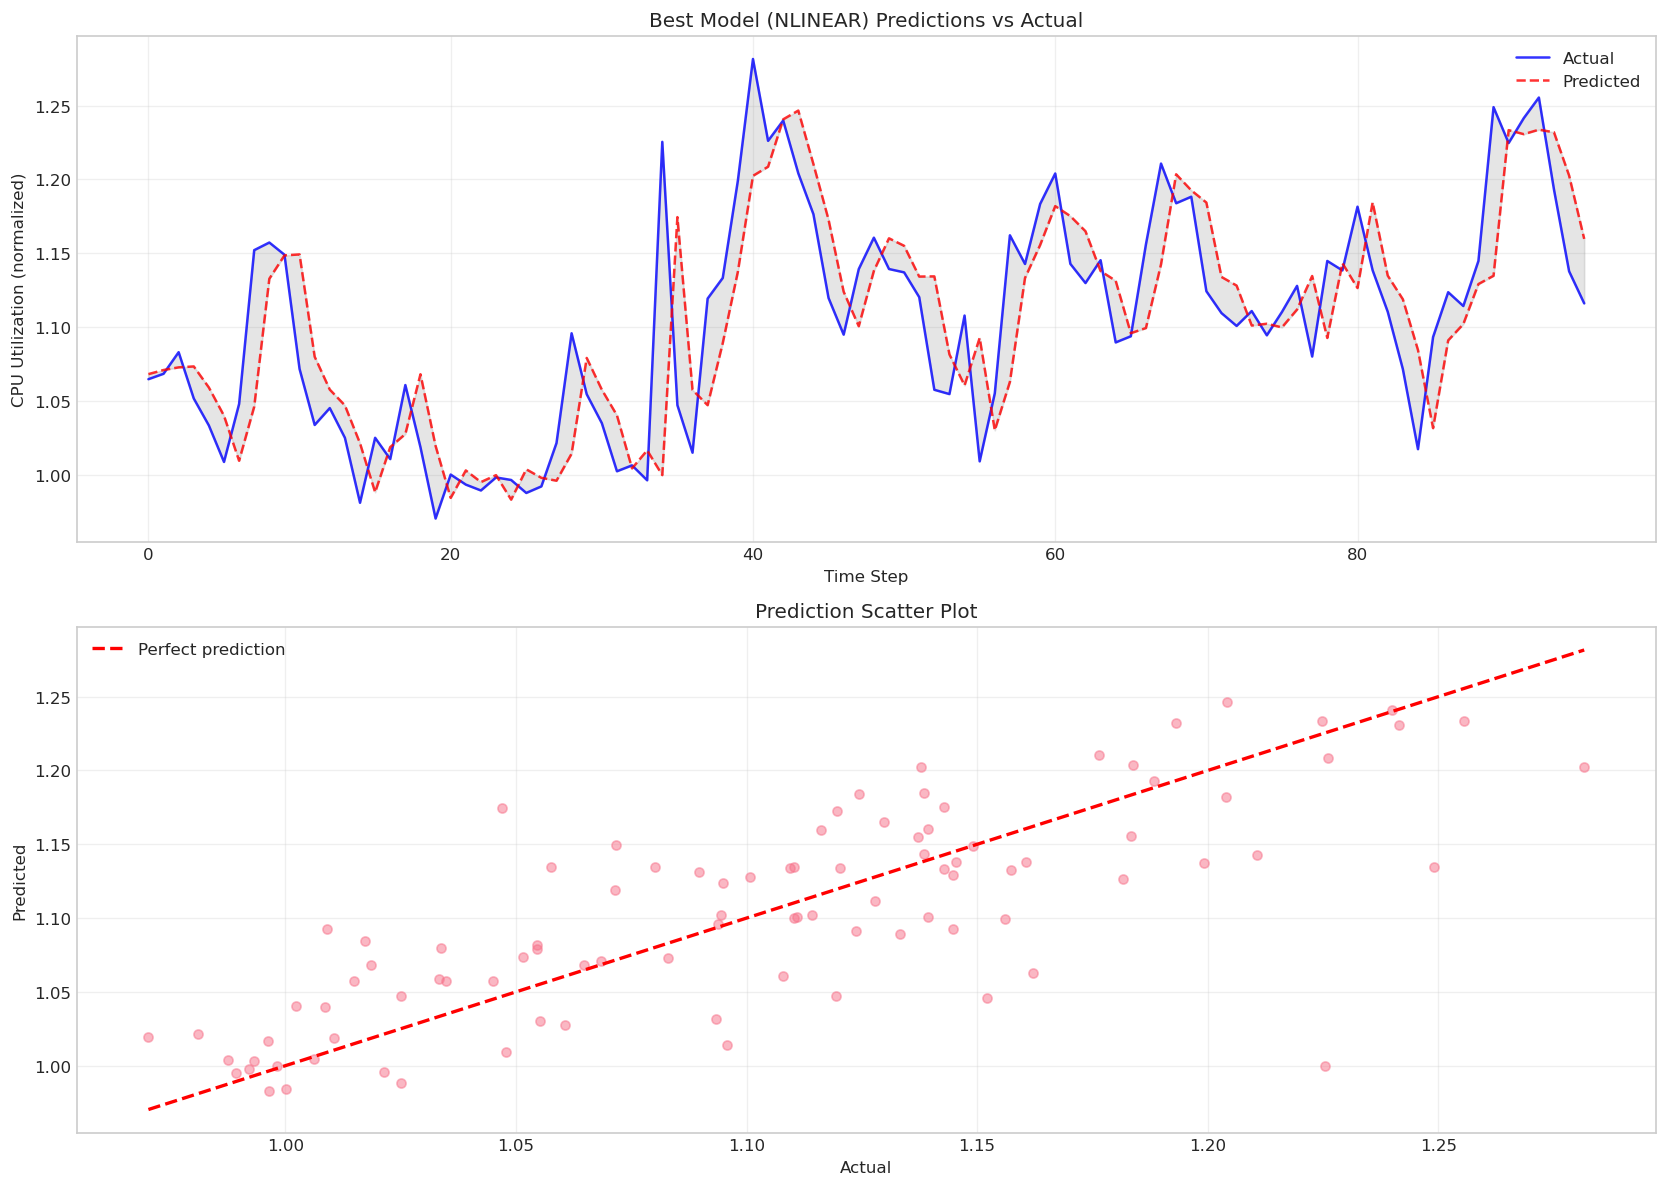


Prediction visualization saved to: /root/repository/clusterdata/cluster-trace-microservices-v2022/workload_prediction/outputs/figures/best_model_predictions.png


In [24]:
# ============================================================
# VISUALIZE BEST MODEL PREDICTIONS
# ============================================================

if 'all_results_df' in dir() and 'all_dl_trainers' in dir():
    # Get best deep learning model
    dl_results = all_results_df[all_results_df['model_class'] == 'Deep Learning']
    if len(dl_results) > 0:
        best_model_name = dl_results.loc[dl_results['rmse'].idxmin(), 'model'].lower()
        
        if best_model_name in all_dl_trainers and all_dl_trainers[best_model_name] is not None:
            best_trainer = all_dl_trainers[best_model_name]
            
            # Get predictions
            predictions, targets = best_trainer.predict(test_loader)
            
            # Plot predictions
            fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=120)
            
            # Time series comparison
            n_points = min(100, len(predictions))
            x = range(n_points)
            
            axes[0].plot(x, targets[:n_points], 'b-', linewidth=1.5, label='Actual', alpha=0.8)
            axes[0].plot(x, predictions[:n_points], 'r--', linewidth=1.5, label='Predicted', alpha=0.8)
            axes[0].fill_between(x, targets[:n_points], predictions[:n_points], alpha=0.2, color='gray')
            axes[0].set_xlabel('Time Step')
            axes[0].set_ylabel('CPU Utilization (normalized)')
            axes[0].set_title(f'Best Model ({best_model_name.upper()}) Predictions vs Actual')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Scatter plot
            axes[1].scatter(targets, predictions, alpha=0.5, s=30)
            min_val, max_val = min(targets.min(), predictions.min()), max(targets.max(), predictions.max())
            axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
            axes[1].set_xlabel('Actual')
            axes[1].set_ylabel('Predicted')
            axes[1].set_title('Prediction Scatter Plot')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(os.path.join(EXPERIMENT_CONFIG.figures_path, 'best_model_predictions.png'), dpi=150)
            plt.show()
            
            print(f'\nPrediction visualization saved to: {EXPERIMENT_CONFIG.figures_path}/best_model_predictions.png')